## Fault Detection by 3D SegNet (3D Shallow U-Net)
Fault detection by U-Net based 3D SegNet trained by a large number of synthetic seismic volumes.
The methodology is described in Xinming Wu et al., 2019, Geophysics Vol 84 No. 3
This notebook starts from the synthetic seismic data generation part.
1. Create 1D reflection model
2. Apply Gaussian deformation
3. Apply planar deformation
4. Add fault throws
5. Convolve reflection model with a wavelet
6. Add some random noise
7. Extract the central part of the volume in the size of 128x128x128

### Import Libraries

In [1]:
import os
import numpy as np
import cupy as cp
import bruges
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy.interpolate import RegularGridInterpolator

### Parameters

In [2]:
class DefineParams():
    def __init__(self, num_data, patch_size):
        ' Feature patch '
        nx, ny, nz = ([patch_size]*3)
        nxy = nx * ny
        nxyz = nxy * nz
        self.nx = nx                    # Number of elements in x
        self.ny = ny                    # Number of elements in y
        self.nz = nz                    # Number of elements in z
        self.nxy = nxy                  # Number of elements in xy
        self.nxyz = nxyz                # Number of elements in xyz
        self.num_data = num_data        # Number of synthetic data        
        self.x0 = int(nx/2)             # Center of x location
        self.y0 = int(ny/2)             # Center of y location
        self.z0 = int(nz/2)             # Center of z location

        ' Synthetic traces '
        size_tr = 200        
        nx_tr, ny_tr, nz_tr = ([size_tr]*3)
        nxy_tr = nx_tr * ny_tr
        nxyz_tr = nxy_tr * nz_tr        
        x = np.linspace(0, nx_tr-1, nx_tr)
        y = np.linspace(0, nx_tr-1, ny_tr)
        z = np.linspace(0, nz_tr-1, nz_tr)
        xy = np.reshape(np.array([np.meshgrid(x, y, indexing='ij')]), [2, nxy_tr]).T
        xyz = np.reshape(np.array([np.meshgrid(x, y, z, indexing='ij')]), [3, nxyz_tr]).T
        self.x = x                      # x
        self.y = y                      # y 
        self.z = z                      # z
        self.xy = xy                    # xy grid (x: xy[:,0], y: xy[:,1])
        self.xyz = xyz                  # xyz grid (x: xyz[:,0], y: xyz[:,1], z: xyz[:,2])        
        self.nx_tr = nx_tr              # Number of elements in x
        self.ny_tr = ny_tr              # Number of elements in y
        self.nz_tr = nz_tr              # Number of elements in z
        self.nxy_tr = nx_tr * ny_tr     # Number of elements in xy
        self.nxyz_tr = nxy_tr * nz_tr   # Number of elements in xyz
        self.x0_tr = int(nx_tr/2)       # Trace center of traces in x
        self.y0_tr = int(ny_tr/2)       # Synthetic Traces: y center
        self.z0_tr = int(nz_tr/2)       # Synthetic Traces: z center

In [3]:
prm = DefineParams(num_data=1, patch_size = 128)

### Start from creating 1D synthetic reflectivity model

In [4]:
def create_1d_model(prm):
    num_rand = int(prm.nz_tr*0.5)
    idx_refl = np.random.randint(0, prm.nz_tr, num_rand)
    refl = np.zeros(prm.nz_tr)
    refl[idx_refl] = 2*np.random.rand(num_rand)-1
    refl = np.tile(refl,[prm.nxy_tr,1])
    return refl

In [5]:
def show_img(img, size=200, idx_img=150):
    plt.imshow(np.reshape(img,[size]*3)[:,idx_img,:].T,cmap=plt.cm.gray_r)
    plt.colorbar()
    plt.show()

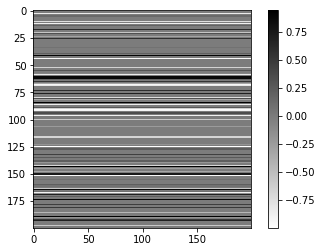

In [6]:
refl = create_1d_model(prm)
show_img(refl)

### Apply 2D Gaussian deformation

In [7]:
def func_gauss2d(prm,refl,a,b,c,d,sigma):
    ''' Apply 2D Gaussian deformation '''
    xy_cp = cp.asarray(prm.xy)
    refl_cp = cp.asarray(refl)    
    a_cp = cp.asarray(a.astype('float64'))
    b_cp = cp.asarray(b.astype('float64'))
    c_cp = cp.asarray(c.astype('float64'))
    d_cp = cp.asarray(d.astype('float64'))
    sigma_cp = cp.asarray(sigma.astype('float64'))    
    z_cp = cp.asarray(prm.z)
    
    # Parallelize computation on GPU using cupy
    func_gauss2d = cp.ElementwiseKernel(
            in_params='T x, T y, T b, T c, T d, T sigma',
            out_params='T z',
            operation=''' z = b*expf(-(powf(x-c,2) + powf(y-d,2))/(2*powf(sigma,2))); ''',
            name='func_gauss2d'
            )
    
    gauss_2d_cp = cp.zeros_like(xy_cp[:,0])            
    for i in range(len(b)):
        gauss_2d_cp += func_gauss2d(xy_cp[:,0],xy_cp[:,1],b_cp[i],c_cp[i],d_cp[i],sigma_cp[i])
    s1_cp = a_cp +(1.5/z_cp)*cp.outer(cp.transpose(gauss_2d_cp),z_cp)

    for i in range(prm.nxy_tr):
        s = s1_cp[i,:] + z_cp
        mat = cp.tile(z_cp,(len(s),1)) - cp.tile(cp.expand_dims(s,1),(1,len(z_cp)))
        refl_cp[i,:] = cp.dot(refl_cp[i,:], cp.sinc(mat))

    refl = np.reshape(cp.asnumpy(refl_cp), [prm.nxy_tr, prm.nz_tr])    
    return refl

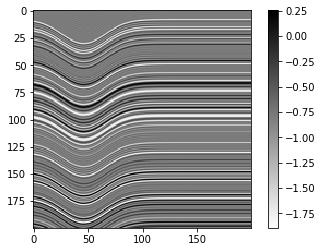

In [8]:
a = np.array([5])            # Offset
b = np.array([15,5])         # Magnitude of deformation 
c = np.array([46,96])        # x0 location
d = np.array([146,46])       # y0 location
sigma = np.array([20,10])    # Size of deformation radius
refl = func_gauss2d(prm,refl,a,b,c,d,sigma)
show_img(refl)

### Apply planar deformation

In [9]:
def func_planar(prm,refl,e,f,g):
    ''' Apply planar deformation '''
    xy_cp = cp.asarray(prm.xy)
    refl_cp = cp.asarray(refl)
    e_cp = cp.asarray(e.astype('float64'))
    f_cp = cp.asarray(f.astype('float64'))
    g_cp = cp.asarray(g.astype('float64'))
    z_cp = cp.asarray(prm.z)

    # Parallelize computation on GPU using cupy    
    func_planar = cp.ElementwiseKernel(
            in_params='T x, T y, T e, T f, T g',
            out_params='T z',
            operation=''' z = e + f*x + g*y; ''',
            name='func_planar'
            )
    
    s2_cp = func_planar(xy_cp[:,0],xy_cp[:,1],e_cp,f_cp,g_cp)

    for i in range(prm.nxy_tr):
        s = s2_cp[i]+z_cp
        mat = cp.tile(z_cp,(len(s),1)) - cp.tile(cp.expand_dims(s,1),(1,len(z_cp)))
        refl_cp[i,:] = cp.dot(refl_cp[i,:], cp.sinc(mat))    
    
    refl = np.reshape(cp.asnumpy(refl_cp), [prm.nxy_tr, prm.nz_tr])
    return refl

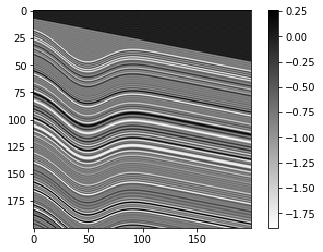

In [10]:
e = np.array([0.1])    # Intercept of the plane
f = np.array([0.2])    # Slope of the plane in x direction
g = np.array([0.05])   # Slope of the plane in y direction
refl = func_planar(prm,refl,e,f,g)
show_img(refl)

<br>

### Add fault throw with linear offset increase

In [11]:
def displace_trace(refl, labels, dip, strike, throw, x0_f, y0_f, z0_f, type_flt,i):
    # z values on a fault plane
    theta = dip/180*np.pi
    phi = strike/180*np.pi
    x, y, z = prm.xyz[:,0], prm.xyz[:,1], prm.xyz[:,2]
    z_flt_plane = z_proj(x, y, z, x0_f, y0_f, z0_f, theta, phi)
    idx_repl = prm.xyz[:,2] <= z_flt_plane
    z_shift, flag_offset = fault_throw(theta, phi, throw, z0_f, type_flt, prm)
    x1 = prm.xyz[:,0] - np.tile(z_shift, prm.nxy_tr)*np.cos(theta)*np.cos(phi)
    y1 = prm.xyz[:,1] - np.tile(z_shift, prm.nxy_tr)*np.cos(theta)*np.sin(phi)
    z1 = prm.xyz[:,2] - np.tile(z_shift, prm.nxy_tr)*np.sin(theta)
    
    # Fault throw
    refl = refl.copy()
    refl = replace(refl, idx_repl, x1, y1, z1, prm)
    refl = np.reshape(refl, [prm.nxy_tr, prm.nz_tr])
    
    # Fault Label
    if i > 0:
        labels = replace(labels, idx_repl, x1, y1, z1, prm)
        labels[labels > 0.4] = 1
        labels[labels <= 0.4] = 0
    flt_flag = (0.5*np.tan(dip/180*np.pi) > abs(z-z_flt_plane)) & flag_offset
    labels[flt_flag] = 1
    return refl, labels

In [12]:
def z_proj(x, y, z, x0_f, y0_f, z0_f, theta, phi):
    x1 = x0_f+(prm.nx_tr-prm.nx)/2
    y1 = y0_f+(prm.ny_tr-prm.ny)/2
    z1 = z0_f+(prm.nz_tr-prm.nz)/2
    z_flt_plane = z1+(np.cos(phi)*(x-x1)+np.sin(phi)*(y-y1))*np.tan(theta)
    return z_flt_plane

In [13]:
def replace(xyz0, idx_repl, x1, y1, z1, prm):
    """ Replace """
    xyz1 = np.reshape(xyz0.copy(),[prm.nx_tr,prm.ny_tr,prm.nz_tr])
    func_3d_interp = RegularGridInterpolator((prm.x, prm.y, prm.z), xyz1, method='linear',
                                             bounds_error=False, fill_value=0)
    idx_interp = np.reshape(idx_repl, prm.nxyz_tr)
    xyz1 = np.reshape(xyz1,prm.nxyz_tr)
    xyz1[idx_interp] = func_3d_interp((x1[idx_interp],y1[idx_interp],z1[idx_interp]))
    return xyz1

In [14]:
def fault_throw(theta, phi, throw, z0_f, type_flt, prm):
    """ Define z shifts"""
    z1 = (prm.nz_tr-prm.nz)/2+z0_f
    z2 = (prm.nz_tr-prm.nz)/2+prm.nz
    z3 = (prm.nz_tr-prm.nz)/2
    if type_flt == 0:     # Linear offset
        if throw > 0:     # Normal fault
            z_shift = throw*np.cos(theta)*(prm.z-z1)/(z2-z1)
            z_shift[z_shift < 0] = 0
        else:             # Reverse fault
            z_shift = throw*np.cos(theta)*(prm.z-z1)/(z3-z1)
            z_shift[z_shift > 0] = 0
    else:                 # Gaussian offset
        gaussian1d = lambda z, sigma: throw*np.sin(theta)*np.exp(-(z-z1)**2/(2*sigma**2))
        z_shift = gaussian1d(prm.z, sigma=20)

    """ Flag offset """
    flag_offset = np.zeros([prm.nxy_tr, prm.nz_tr], dtype=bool)
    for i in range(prm.nxy_tr):
        flag_offset[i,:] = np.abs(z_shift) > 1
    flag_offset = np.reshape(flag_offset, prm.nxyz_tr)
    return z_shift, flag_offset


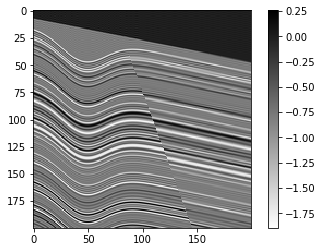

In [15]:
type_flt = np.array([0])   # Fault type (0: Linear throw, 1: Gaussian throw)
x0_f = np.array([50])      # x-location of fault (Gaussian: center, Linear: start point)
y0_f = np.array([0])       # y-location of fault
z0_f = np.array([0])       # z-location of fault
throw = np.array([30])     # Fault throw (Normal fault: > 0, Reverse fault: < 0)
dip = np.array([70])       # Fault dip (0 deg < dip < 90 deg)
strike = np.array([0])     # Fault strike (0 deg < strike <= 360 deg)

labels = np.zeros(prm.nxyz_tr)
for i in range(len(throw)):
    refl, labels = displace_trace(refl, labels, dip[i], strike[i], throw[i],
                                  x0_f[i], y0_f[i], z0_f[i], type_flt[i], i)
show_img(refl)

### Convolve reflectivity model with a Ricker wavelet 

In [16]:
def convolve_wavelet(prm, refl):
    traces = np.zeros([prm.nxy_tr, prm.nz_tr])
    wl = bruges.filters.wavelets.ricker(t_lng, dt, 30)
    for i in range(prm.nxy_tr):
        traces[i,:] = np.convolve(refl[i,:], wl, mode='same')
    return traces

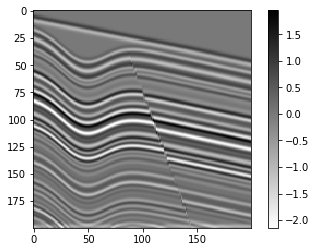

In [17]:
dt = 0.004        # Sampling interval (ms)
t_lng = 0.082     # Length of Ricker wavelet in ms
traces = convolve_wavelet(prm, refl)
show_img(traces)

### Add some noise to traces to imitate real seismic data

In [18]:
def add_noise(traces, snr, f0):
    nyq = 1 / dt / 2
    low = lcut / nyq
    high = hcut / nyq
    b, a = butter(order, [low, high], btype='band')
    for i in range(prm.nxy_tr):
        noise = bruges.noise.noise_db(traces[i,:], 3)
        traces[i,:] = filtfilt(b, a, traces[i,:] + noise)
    return traces

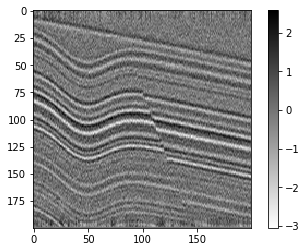

In [19]:
snr = np.array([3])            # Signal Noise Ratio
f0 = np.array([30])            # Central frequency
dt = 0.004                     # Sampling interval (ms)
lcut = 5                       # Bandpass filter: Lower cutoff
hcut = 80                      # Bandpass filter: Upper cutoff
order = 5                      # Order of Butterworth Filter
traces = add_noise(traces, snr, f0)
show_img(traces)

### Extract the central part in the input size

In [20]:
def crop_center_patch(prm, traces, labels):
    def func_crop(xyz):
        xyz = np.reshape(xyz, [prm.nx_tr, prm.ny_tr, prm.nz_tr])
        xyz_crop = xyz[prm.x0_tr-prm.x0:prm.x0_tr+prm.x0,
                       prm.y0_tr-prm.y0:prm.y0_tr+prm.y0,
                       prm.z0_tr-prm.z0:prm.z0_tr+prm.z0]
        return np.reshape(xyz_crop, [prm.nxy, prm.nz])
    traces = func_crop(traces)
    labels = np.reshape(labels, [prm.nxy_tr, prm.nz_tr])
    labels = func_crop(labels)
    return traces, labels

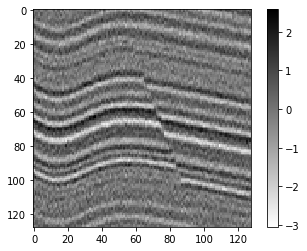

In [21]:
traces, labels = crop_center_patch(prm, traces, labels)
show_img(traces, 128, 150-36)

### Standardize amplitudes within the image

In [22]:
def standardizer(traces):
    std_func = lambda x: (x - np.mean(x)) / np.std(x)
    tr_std = std_func(traces)
    tr_std[tr_std > 1] = 1
    tr_std[tr_std < -1] = -1
    traces = tr_std
    return traces

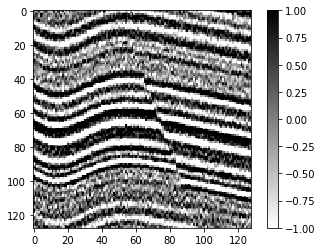

In [23]:
traces = standardizer(traces)
show_img(traces, 128, 150-36)

### Display x-, y-, and z- slices with and without fault label

In [24]:
def CreateImgAlpha(img_input):
    img_alpha = np.zeros([np.shape(img_input)[0],np.shape(img_input)[1],4])
    # Yellow: (1,1,0), Red: (1,0,0)
    img_alpha[:,:,0] = 1
    img_alpha[:,:,1] = 0
    img_alpha[:,:,2] = 0
    img_alpha[..., -1] = img_input
    return img_alpha

In [25]:
def show_img_slice(seis_slice, fault_slice, title, cmap_bg=plt.cm.gray_r, i=63):
    plt.figure(figsize=(8,12))
    for j in range(2):
        plt.subplot(int(221+j))
        plt.imshow(seis_slice.T, cmap_bg)
        if j == 1:
            img_alpha = CreateImgAlpha(fault_slice.T)
            plt.imshow(img_alpha, alpha=1)
            plt.title(title + ' with fault')
        else:
            plt.title(title)
        plt.tight_layout()
    plt.show()

In [26]:
seis_vlm = np.reshape(traces,[128]*3)
fault_vlm = np.reshape(labels,[128]*3)
idx = 100

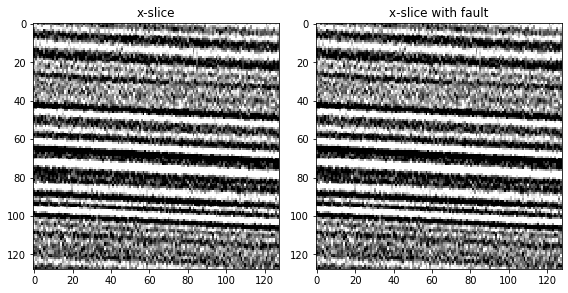

In [27]:
show_img_slice(seis_vlm[idx,:,:], fault_vlm[idx,:,:], 'x-slice')

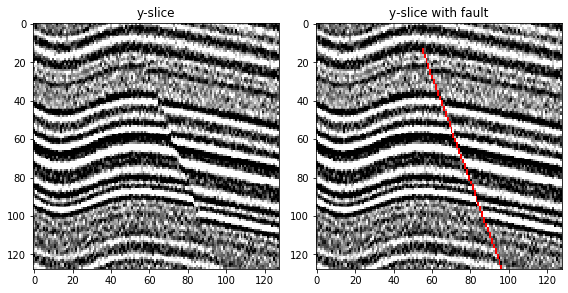

In [28]:
show_img_slice(seis_vlm[:,idx,:], fault_vlm[:,idx,:], 'y-slice')

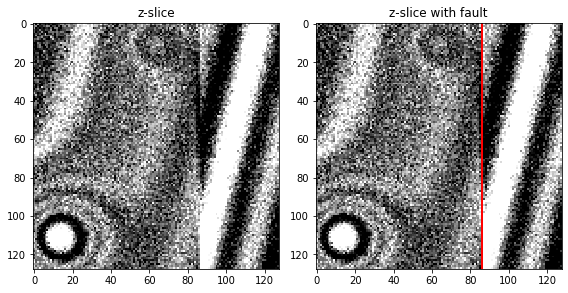

In [29]:
show_img_slice(seis_vlm[:,:,idx], fault_vlm[:,:,idx], 'z-slice')

### Show one example of synthetic volume with multiple faults

In [30]:
def load_data_synth(path_dataset, name_file, size_vlm):
    ''' Load already generated data '''
    path_seis = os.path.join(path_dataset, 'seis', name_file)
    path_fault = os.path.join(path_dataset, 'fault', name_file)
    path_pred = os.path.join(path_dataset, 'pred', name_file)
    seis_vlm = np.fromfile(path_seis,dtype=np.single)
    fault_vlm = np.fromfile(path_fault,dtype=np.single)
    pred_vlm = np.fromfile(path_pred,dtype=np.single)
    seis_vlm = np.reshape(seis_vlm, size_vlm)
    fault_vlm = np.reshape(fault_vlm, size_vlm)
    pred_vlm = np.reshape(pred_vlm, size_vlm)
    return seis_vlm, fault_vlm, pred_vlm

In [31]:
path_dataset = './dataset/12.07.2019/train'
seis_vlm, fault_vlm, pred_vlm = load_data_synth(path_dataset,'100.dat',(128,128,128))

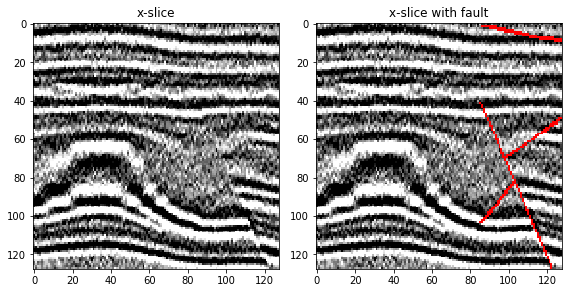

In [32]:
show_img_slice(seis_vlm[idx,:,:], fault_vlm[idx,:,:], 'x-slice')

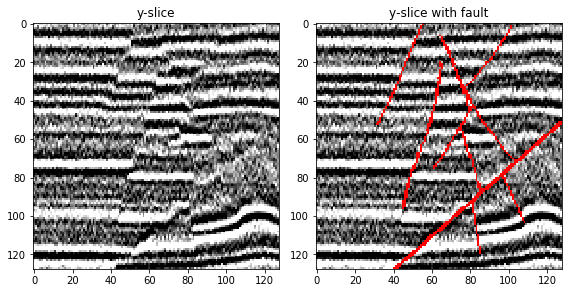

In [33]:
show_img_slice(seis_vlm[:,idx,:], fault_vlm[:,idx,:], 'y-slice')

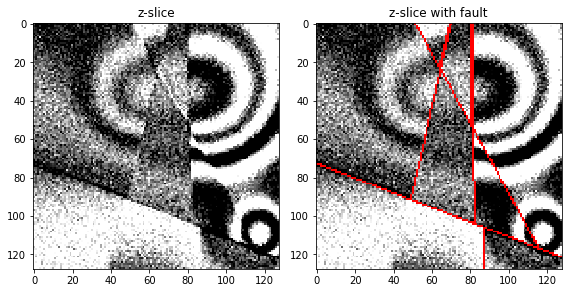

In [34]:
show_img_slice(seis_vlm[:,:,idx], fault_vlm[:,:,idx], 'z-slice')

## Model Training & Prediction part
After preparing training dataset using the methodology above, we're going to creat and train a model
that predicts fault probability using segmentation technique.

### Import Libraries

In [35]:
import json
from time import time
from obspy.io.segy.segy import _read_segy
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import keras
from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from keras import callbacks, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm

Using TensorFlow backend.


### Metrics used in 3D SegNet model

In [36]:
def _to_tensor(x, dtype):
    ''' Convert the input `x` to a tensor of type `dtype`. '''
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

In [37]:
def cross_entropy_balanced(y_true, y_pred):
    ''' 
    tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits, 
    Keras expects probabilities. transform y_pred back to logits
    '''
    _epsilon = _to_tensor(K.epsilon(), y_pred.dtype.base_dtype)
    y_pred   = tf.clip_by_value(y_pred, _epsilon, 1 - _epsilon)
    y_pred   = tf.log(y_pred/ (1 - y_pred))
    y_true = tf.cast(y_true, tf.float32)
    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)
    beta = count_neg / (count_neg + count_pos)
    pos_weight = beta / (1 - beta)
    cost = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred, targets=y_true, pos_weight=pos_weight)
    cost = tf.reduce_mean(cost * (1 - beta))
    return tf.where(tf.equal(count_pos, 0.0), 0.0, cost)

### SegNet3D (Shallow 3D U-Net)

In [38]:
def Conv3D_with_prm(model_in, num_filters):
    ''' Wrapper function to add a conv3D layer to an existing model. '''
    conv = Conv3D(filters=num_filters,
                  kernel_size=(3,3,3),
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(model_in)
    return conv

In [39]:
def conv3d_down(model_in, num_filters, pooling=False):
    ''' Encoder part (Downward Conv3d Layer Block) '''
    pool = []
    conv = Conv3D_with_prm(model_in, num_filters)
    conv = Conv3D_with_prm(conv, num_filters)
    if pooling:
        pool = MaxPooling3D(pool_size=(2,2,2))(conv)
    return conv, pool

In [40]:
def conv3d_up(model_in, model_merge, num_filters):
    ''' Decoder part (Upward Conv3d Layer Block) '''    
    up = UpSampling3D(size=(2,2,2))(model_in)
    merge = concatenate([up, model_merge], axis=4)
    conv = Conv3D_with_prm(merge, num_filters)
    conv = Conv3D_with_prm(conv, num_filters)
    return conv

In [41]:
def compile_convnet(input_size, lr):
    ''' Compile 3D ConvnNets '''
    # Downward
    inputs = Input(input_size)    
    conv1, pool1 = conv3d_down(inputs, 2**4, pooling=True)
    conv2, pool2 = conv3d_down(pool1, 2**5, pooling=True)
    conv3, pool3 = conv3d_down(pool2, 2**6, pooling=True)
    
    # Bottom
    conv4 = Conv3D_with_prm(pool3, 2**9)
    conv4 = Conv3D_with_prm(conv4, 2**9)

    # Upward
    conv5 = conv3d_up(conv4, conv3, 2**6)
    conv6 = conv3d_up(conv5, conv2, 2**5)
    conv7 = conv3d_up(conv6, conv1, 2**4)
    outputs = Conv3D(1, kernel_size=(1,1,1), activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(lr),
                  loss=cross_entropy_balanced, metrics=['acc'])
    return model

In [42]:
lr=1e-3
patch_size = 128
num_data_tr = 200
num_data_val = 20
num_epochs = 30
model = compile_convnet(tuple([patch_size]*3 + [1]),lr)

### Path definition for dataset, model, and trained weights

In [43]:
name_model = 'SegNet3D'
name_dataset = '12.07.2019'
name_weights = 'model_lr_1.0e-03_30_epochs'

path_home = './'
tr_path = os.path.join(path_home, 'dataset', name_dataset, 'train')
vl_path = os.path.join(path_home, 'dataset', name_dataset, 'validation')
tdpath = os.path.join(tr_path, 'seis')
tfpath = os.path.join(tr_path, 'fault')
vdpath = os.path.join(vl_path, 'seis')
vfpath = os.path.join(vl_path, 'fault')

''' Paths for model, weights, and metircs '''    
path_model = os.path.join(path_home, 'model')
path_weights = os.path.join(path_model, 'weights', name_weights + '.h5')
path_hists = os.path.join(path_model, 'weights', name_weights + '_hist.txt')
path_cb = os.path.join(path_model, 'call_back', name_weights)

### Train the model from scratch

In [44]:
class DataGenerator(keras.utils.Sequence):
    ''' Generates data for keras '''
    
    def __init__(self, dpath, fpath, data_IDs, batch_size=1, num_data_aug=4,
                 dim=(128,128,128), n_channels=1, shuffle=True):
        'Initialization'
        self.dim   = dim
        self.dpath = dpath
        self.fpath = fpath
        self.batch_size = batch_size
        self.num_data_aug = num_data_aug
        self.data_IDs   = data_IDs
        self.n_channels = n_channels
        self.shuffle    = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_IDs)/self.batch_size))

    def __getitem__(self, index):
        'Generates one batch of data'
        bsize = self.batch_size
        indexes = self.indexes[index*bsize:(index+1)*bsize] # Generate indexes of the batch

        # Find list of IDs
        data_IDs_temp = [self.data_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(data_IDs_temp)
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, data_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.num_data_aug, *self.dim, self.n_channels),dtype=np.single)
        Y = np.zeros((self.num_data_aug, *self.dim, self.n_channels),dtype=np.single)
        gx  = np.fromfile(os.path.join(self.dpath,str(data_IDs_temp[0])+'.dat'),dtype=np.single)
        fx  = np.fromfile(os.path.join(self.fpath,str(data_IDs_temp[0])+'.dat'),dtype=np.single)
        gx = np.reshape(gx,self.dim)
        fx = np.reshape(fx,self.dim)
        # data augmentation
        idx_rot = np.random.randint(0, 4, self.num_data_aug)
        for i in range(self.num_data_aug):
            X[i,] = np.reshape(np.rot90(gx,idx_rot[i],(0,1)), (*self.dim,self.n_channels))
            Y[i,] = np.reshape(np.rot90(fx,idx_rot[i],(0,1)), (*self.dim,self.n_channels))  
        return X,Y

In [45]:
class MyEncoder(json.JSONEncoder):
    ''' This function converts an object in to float64 to save trained weights'''
    def default(self, obj):
        return float(obj)

In [ ]:
# Define Callbacks
cp_fn = os.path.join(path_cb, 'checkpoint.{epoch:02d}.h5')
model_checkpoint = ModelCheckpoint(filepath=cp_fn, verbose=0, save_best_only=False)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=1e-5,verbose=0)
early_stopping = EarlyStopping(patience=10, verbose=0)
cbks = [model_checkpoint,early_stopping, reduce_lr, TQDMNotebookCallback()]
# Specify Data Generator
params = {'batch_size': 1, 'num_data_aug': 3, 'dim':([patch_size]*3),
          'n_channels': 1, 'shuffle': True}
tdata_IDs = range(num_data_tr)
vdata_IDs = range(num_data_val)
tr_gen = DataGenerator(dpath=tdpath,fpath=tfpath,data_IDs=tdata_IDs,**params)
val_gen = DataGenerator(dpath=vdpath,fpath=vfpath,data_IDs=vdata_IDs,**params)
# Model Fitting
history = model.fit_generator(generator=tr_gen, validation_data=val_gen,
                              epochs=num_epochs, verbose=0, callbacks=cbks)
''' Save Weights & Metrics '''
history_dict = history.history
model.save_weights(path_weights)
json.dump(history_dict, open(path_hists, 'w'), cls=MyEncoder)

### Load trained weights onto the model

In [47]:
model.load_weights(path_weights)
history_dict = json.load(open(path_hists, 'r'))

### Show some training results

In [48]:
def plot_metrics(metric_tr,metric_val,title,label_metric):
    ''' Plot metrics history during training '''
    plt.plot(metric_tr)
    plt.plot(metric_val)
    plt.title(title,fontsize=12)
    plt.ylabel(label_metric,fontsize=12)
    plt.xlabel('Epoch',fontsize=12)
    plt.legend(['train', 'validation'],fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

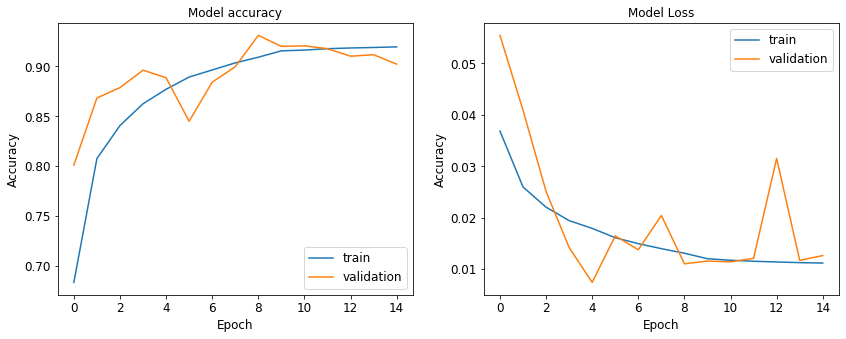

In [49]:
plt.subplots(1, 2, figsize=(14,5))
plt.subplot(121)
plot_metrics(history_dict['acc'],history_dict['val_acc'],'Model accuracy','Accuracy')
plt.subplot(122)
plot_metrics(history_dict['loss'],history_dict['val_loss'],'Model Loss','Accuracy')
plt.show()

### Prediction

In [50]:
def pred_subvlms(path_dataset, model, patch_size=128):
    ''' Predict fault probability for a single seismic sub-volume'''
    size_vlm=np.array([1,1,1])*patch_size  
    path_seis = os.path.join(path_dataset, 'seis')
    path_pred = os.path.join(path_dataset, 'pred')
    if not os.path.exists(path_pred):
        os.makedirs(path_pred)

    for file in tqdm(os.listdir(path_seis)):
        if file.endswith('.dat'):
            path_read = os.path.join(path_seis, file)
            path_write = os.path.join(path_pred, file)     
            seis_vlm = np.fromfile(path_read,dtype=np.single)
            seis_vlm_reshaped = np.reshape(seis_vlm,(1,*size_vlm,1))
            pred_vlm = model.predict(seis_vlm_reshaped)
            fs = open(path_write, 'bw')
            pred_vlm.flatten().astype('float32').tofile(fs, format='%.4f')
            fs.close()

In [51]:
def load_data_synth(path_dataset, name_file, size_vlm):
    ''' Load synthetic seismic sub-volume from a binary file'''
    path_seis = os.path.join(path_dataset, 'seis', name_file)
    path_fault = os.path.join(path_dataset, 'fault', name_file)
    path_pred = os.path.join(path_dataset, 'pred', name_file)
    seis_vlm = np.fromfile(path_seis,dtype=np.single)
    fault_vlm = np.fromfile(path_fault,dtype=np.single)
    pred_vlm = np.fromfile(path_pred,dtype=np.single)
    seis_vlm = np.reshape(seis_vlm, size_vlm)
    fault_vlm = np.reshape(fault_vlm, size_vlm)
    pred_vlm = np.reshape(pred_vlm, size_vlm)
    return seis_vlm, fault_vlm, pred_vlm

In [52]:
def plot_roc(ytest,yprob):
    ''' Plot Receiver Operating Characteristic (ROC) '''
    lr_auc = roc_auc_score(ytest,yprob)
    lr_fpr, lr_tpr, _ = roc_curve(ytest,yprob)
    precision, recall, thresholds = precision_recall_curve(ytest,yprob)
    plt.subplots(1,2,figsize=(12,5))
    plt.subplot(121)
    plt.plot(recall, precision, 'b-')
    plt.xlabel('Recall',fontsize=12)
    plt.ylabel('Precision',fontsize=12)
    plt.subplot(122)
    plt.plot(lr_fpr, lr_tpr, 'r-')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.show()

In [53]:
name_subset = ['train','validation']
path_dataset_tr  = os.path.join(path_home,'dataset',name_dataset,name_subset[0])
path_dataset_val = os.path.join(path_home,'dataset',name_dataset,name_subset[1])

''' Synthetic Data Application '''
pred_subvlms(path_dataset_tr,  model) # Training Data
pred_subvlms(path_dataset_val, model) # Validation Data

seis_vlms = np.zeros([num_data_val] + [patch_size]*3)
fault_vlms = np.zeros_like(seis_vlms)
pred_vlms = np.zeros_like(seis_vlms)
for i in range(num_data_val):
    filename = str(i) + '.dat'
    seis_vlms[i,...], fault_vlms[i,...], pred_vlms[i,...] = \
        load_data_synth(path_dataset_val,filename,tuple([patch_size]*3))

100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


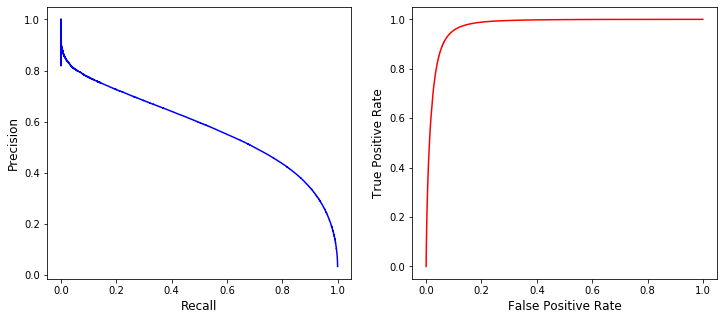

In [54]:
plot_roc(fault_vlms.flatten(),pred_vlms.flatten())

### Visualize some of the trained weights

In [55]:
def deprocess_image(x):
    ''' Utility function to convert a tensor into a valid image '''
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [56]:
def generate_pattern(model, layer_output, filter_index, size):
    ''' Function to generate filter visualizations '''
    loss = K.mean(layer_output[:,:,:,:,filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1,size,size,size,1)) * 20 + 128
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return np.reshape(deprocess_image(img),[size,size,size])

In [57]:
def plt_filter_patterns(model, layer_name):
    ''' Plot filter pattens '''
    layer_output = model.get_layer(layer_name).output
    size = layer_output.get_shape().as_list()[1]
    margin = int(5 - np.log2(128/size))
    results = np.zeros((2*size + 1*margin, 8*size + 7*margin))
    for i in range(2):
        for j in range(8):
            filter_img = generate_pattern(model,layer_output, j + (i * 8) , size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,vertical_start:vertical_end] = filter_img.T[:,:,15]
    
    plt.figure(figsize=(14,8))
    plt.imshow(results,cmap='gray')
    plt.title(layer_name)
    plt.tick_params(axis='both',which='both',bottom=False,left=False,labelleft=False,labelbottom=False)
    plt.show()

In [58]:
def plt_filter_patterns(model, layer_name,idx_slice=None):
    ''' Plot filter pattens '''
    layer_output = model.get_layer(layer_name).output
    size = layer_output.get_shape().as_list()[1]
    num_ftr = layer_output.get_shape().as_list()[-1]
    margin = int(5 - np.log2(128/size))
    results = np.zeros((8*size + 7*margin,3*size + 2*margin))
    
    if not idx_slice:
        idx_slice = int(size / 2)
        
    idx_feature = np.arange(num_ftr)
    np.random.shuffle(idx_feature)
    for i in range(8):
        filter_img = generate_pattern(model,layer_output, idx_feature[i], size)
        hrz_start = i * size + i * margin
        hrz_end = hrz_start + size
        for j in range(3):
            vrt_start = j * size + j * margin
            vrt_end = vrt_start + size
            if j == 0: # x-slice
                results[hrz_start:hrz_end,vrt_start:vrt_end] = filter_img.T[idx_slice,:,:]
            elif j == 1: # y-slice
                results[hrz_start:hrz_end,vrt_start:vrt_end] = filter_img.T[:,idx_slice,:]
            elif j == 2: # z-slice
                results[hrz_start:hrz_end,vrt_start:vrt_end] = filter_img.T[:,:,idx_slice]
    
    plt.figure(figsize=(14,8))
    ax = plt.axes()    
    plt.imshow(results.T,cmap='gray')
    ax.set_yticks([i*size+i*margin+int(size/2) for i in np.arange(3)])
    ax.set_yticklabels(['x-slice', 'y-slice', 'z-slice'])    
    plt.title(layer_name)
    plt.tick_params(axis='both',which='both',bottom=False,labelbottom=False)
    plt.show()

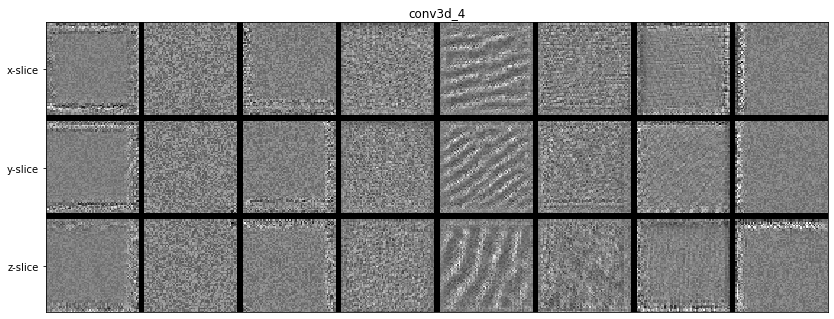

In [59]:
plt_filter_patterns(model,'conv3d_4') # 64 x 64 x 64 (downward conv3d)

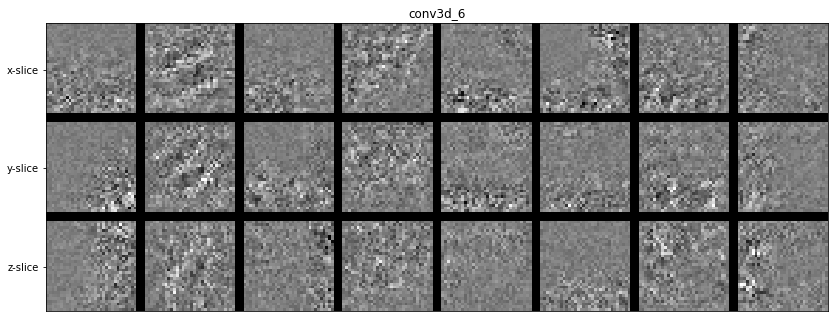

In [60]:
plt_filter_patterns(model,'conv3d_6') # 32 x 32 x 32 (downward conv3d)

### Show some prediction results

In [61]:
def create_img_alpha(img_input,threshold=0.5):
    ''' Overlay a translucent fault image on a seismic image '''
    img_alpha = np.zeros([np.shape(img_input)[0], np.shape(img_input)[1],4])
    img_input[img_input < threshold] = 0
    img_alpha[:,:,0] = 1 # Yellow: (1,1,0), Red: (1,0,0)
    img_alpha[:,:,1] = 0
    img_alpha[:,:,2] = 0
    img_alpha[...,-1] = img_input
    return img_alpha

In [62]:
def vlm_slicer(seis_vlms,pred_vlms,fault_vlms,idx_vlm=0,idx_slice=0,flag_slice=0):
    ''' Slice a seismic sub-volume for display '''
    seis_vlms = seis_vlms.copy()
    pred_vlms = pred_vlms.copy()
    fault_vlms = pred_vlms.copy()
    seis_vlm = seis_vlms[idx_vlm,...].copy()
    fault_vlm = fault_vlms[idx_vlm,...].copy()
    pred_vlm = pred_vlms[idx_vlm,...].copy()
    if   flag_slice == 0:
        seis_slice = seis_vlm[:,:,idx_slice]
        fault_slice = fault_vlm[:,:,idx_slice]
        pred_slice = pred_vlm[:,:,idx_slice]
        prefix = 'z-slice'
    elif flag_slice == 1:
        seis_slice = seis_vlm[:,idx_slice,:]
        fault_slice = fault_vlm[:,idx_slice,:]
        pred_slice = pred_vlm[:,idx_slice,:]
        prefix = 'y-slice'
    elif flag_slice == 2:
        seis_slice = seis_vlm[idx_slice,:,:]
        fault_slice = fault_vlm[idx_slice,:,:]
        pred_slice = pred_vlm[idx_slice,:,:]
        prefix = 'x-slice'
    title = 'Test Volume ID: ' + str(idx_vlm) + ', ' + prefix + ': ' + str(idx_slice)
    return seis_slice, fault_slice, pred_slice, title

In [63]:
def show_image_synth(seis_slice, fault_slice, pred_slice, title, threshold):
    ''' Show fault prediction result on synthetic data for validation '''
    fig, axes = plt.subplots(1,3,figsize=(14,5))
    for i,ax in enumerate(axes.flat):
        plt.axes(ax)
        plt.imshow(seis_slice.T,cmap=plt.cm.gray_r)
        if  i == 0:
            plt.title('Seismic')
        elif i == 1:
            plt.imshow(create_img_alpha(pred_slice.T,threshold), alpha=0.5)
            plt.title('Fault Probability')            
        elif i == 2: 
            plt.imshow(create_img_alpha(fault_slice.T), alpha=0.5)
            plt.title('True Mask')
        plt.tick_params(axis='both',which='both',bottom=False,left=False,labelleft=False,labelbottom=False)
    plt.text(-145,140,title,fontsize=14)
    plt.show()

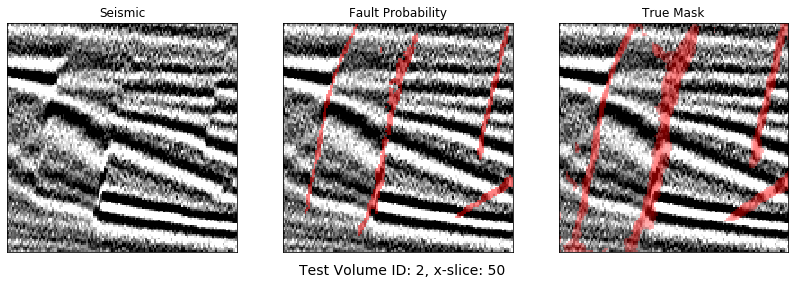

In [64]:
seis_slice, fault_slice, pred_slice, title = \
    vlm_slicer(seis_vlms,pred_vlms,fault_vlms,idx_vlm=2,idx_slice=50,flag_slice=2)
show_image_synth(seis_slice, fault_slice, pred_slice, title, threshold=0.9)

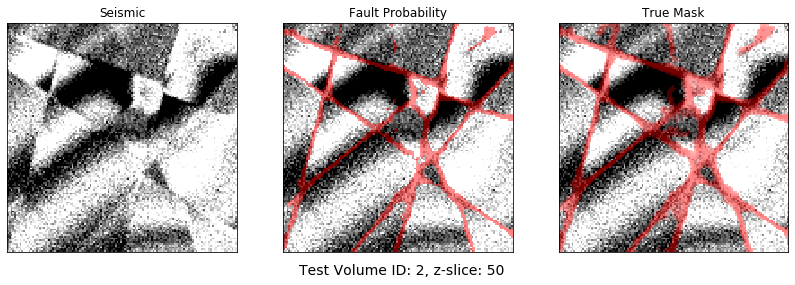

In [65]:
seis_slice, fault_slice, pred_slice, title = \
    vlm_slicer(seis_vlms,pred_vlms,fault_vlms,idx_vlm=2,idx_slice=50,flag_slice=0)
show_image_synth(seis_slice, fault_slice, pred_slice, title, threshold=0.8)

### Application of the trained model to field data (F3)

In [66]:
def dataload_segy(path_seis,size_vlm,idx0_vlm):
    ''' This function loads a segy file and quary a subvolume defined by size_vlm and idx0_vlm '''
    file_segy = _read_segy(path_seis).traces
    traces = np.stack([t.data for t in file_segy])
    inlines = np.stack([t.header.for_3d_poststack_data_this_field_is_for_in_line_number for t in file_segy])
    xlines = np.stack([t.header.for_3d_poststack_data_this_field_is_for_cross_line_number for t in file_segy])
    idx_inline = inlines - np.min(inlines)
    idx_xline = xlines - np.min(xlines)
    num_traces = len(traces)
    num_inline = len(np.unique(inlines))
    num_xline = len(np.unique(xlines))
    num_sample = len(file_segy[0].data)
    seis_vlm = np.zeros([num_inline, num_xline, num_sample])
    for i in range(num_traces):
        seis_vlm[idx_inline[i],idx_xline[i],:] = traces[i]
    seis_vlm = seis_vlm[idx0_vlm[0]:idx0_vlm[0]+size_vlm[0],
                        idx0_vlm[1]:idx0_vlm[1]+size_vlm[1],
                        idx0_vlm[2]:idx0_vlm[2]+size_vlm[2]]
    return seis_vlm

In [67]:
def getMask(os,size_subvlm):
    ''' Set gaussian weights in the overlap bounaries '''
    n1, n2, n3 = size_subvlm[0],size_subvlm[1],size_subvlm[2]
    sc = np.zeros(size_subvlm,dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)

    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n2-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

In [68]:
def apply_trained_net(model,seis_vlm,size_subvlm,size_vlm):
    '''
    a 3d array of gx[m1][m2][m3], please make sure the dimensions are correct
    we strongly suggest to gain the seismic image before input it to the faultSeg
    '''
    size_vlm = np.shape(seis_vlm)
    n1, n2, n3 = size_subvlm[0],size_subvlm[1],size_subvlm[2]
    m1, m2, m3 = size_vlm[0],size_vlm[1],size_vlm[2]

    stdizer = lambda x: (x - np.mean(x)) / np.std(x)    
    os = 12 #overlap width
    c1 = np.round((m1+os)/(n1-os)+0.5)
    c2 = np.round((m2+os)/(n2-os)+0.5)
    c3 = np.round((m3+os)/(n3-os)+0.5)
    c1 = int(c1)
    c2 = int(c2)
    c3 = int(c3)
    p1 = (n1-os)*c1+os
    p2 = (n2-os)*c2+os
    p3 = (n3-os)*c3+os
    gx = np.reshape(seis_vlm,(m1,m2,m3))
    gp = np.zeros((p1,p2,p3),dtype=np.single)
    gy = np.zeros((p1,p2,p3),dtype=np.single)
    mk = np.zeros((p1,p2,p3),dtype=np.single)
    gs = np.zeros((1,*size_subvlm,1),dtype=np.single)
    gp[0:m1,0:m2,0:m3] = gx
    sc = getMask(os,size_subvlm)
    for k1 in range(c1):
        for k2 in range(c2):
            for k3 in range(c3):
                b1 = k1*n1-k1*os
                e1 = b1+n1
                b2 = k2*n2-k2*os
                e2 = b2+n2
                b3 = k3*n3-k3*os
                e3 = b3+n3
                gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
                gs = stdizer(gs)                
                Y = model.predict(gs)
                Y = np.array(Y)
                gy[b1:e1,b2:e2,b3:e3] = gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
                mk[b1:e1,b2:e2,b3:e3] = mk[b1:e1,b2:e2,b3:e3]+sc
    gy = gy/mk
    pred_vlm = gy[0:m1,0:m2,0:m3]
    return pred_vlm

In [69]:
def show_image_field_data(seis_vlm, pred_vlm, title, idx_slice, threshold=0.5, flag_slice=0):
    ''' Show fault prediction result on field data '''
    seis_vlm = seis_vlm.copy()
    pred_vlm = pred_vlm.copy()
    if   flag_slice == 0:
        seis_slice = seis_vlm[:,:,idx_slice]
        pred_slice = pred_vlm[:,:,idx_slice]
        prefix = 'z-slice'
    elif flag_slice == 1:
        seis_slice = seis_vlm[:,idx_slice,:]
        pred_slice = pred_vlm[:,idx_slice,:]
        prefix = 'y-slice'
    elif flag_slice == 2:
        seis_slice = seis_vlm[idx_slice,:,:]
        pred_slice = pred_vlm[idx_slice,:,:]
        prefix = 'x-slice'
        
    # Display images
    fig = plt.figure(figsize=(14, 6))
    plt.imshow(seis_slice.T,cmap=plt.cm.gray_r,vmin=0.1, vmax=0.9,)
    img_alpha = create_img_alpha(pred_slice.T, threshold)
    plt.imshow(img_alpha, alpha=0.5)
    plt.tick_params(axis='both',which='both',
                    bottom=False,left=False,labelleft=False,labelbottom=False)
    plt.title('F3 Block, ' + prefix + ': ' +str(idx_slice))
    plt.show()

In [70]:
path_seis = './F3_seismic.sgy'
size_data = tuple(patch_size*np.array([4,3,2]))
idx0_subvlm = (0,0,200)

''' Field Data Application '''
standardizer = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))
seis_vlm_F3 = standardizer(dataload_segy(path_seis, size_data, idx0_subvlm))
pred_vlm_F3 = apply_trained_net(model,seis_vlm_F3,tuple([patch_size]*3),size_data)

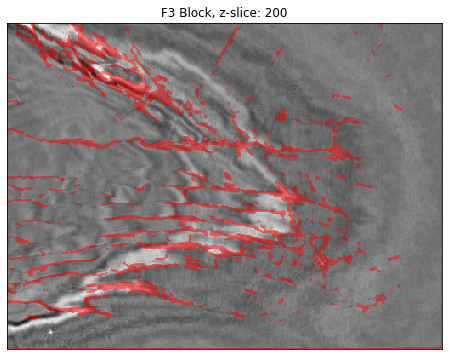

In [71]:
show_image_field_data(seis_vlm_F3, pred_vlm_F3, title, idx_slice=200, threshold=0.8, flag_slice=0)

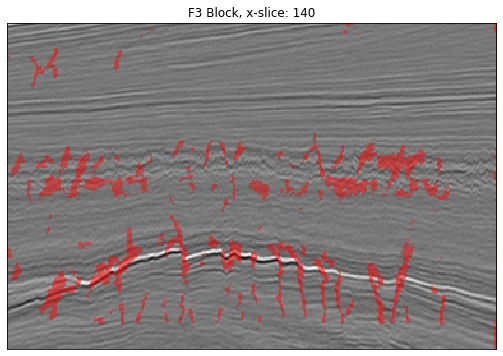

In [72]:
show_image_field_data(seis_vlm_F3, pred_vlm_F3, title, idx_slice=140, threshold=0.8, flag_slice=2)